# GNN node feature dynamics analysis
Discrete graph neural network solving the node classification task.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

import torch 
from torch_geometric.utils import get_laplacian, degree, to_edge_index #,homophily
from sklearn.preprocessing import normalize
import torch_sparse

from utils import load_synthetic_data
from models import GRAFFNet, GCN

In [2]:
# %matplotlib notebook

In [2]:
adj, labels, degrees, features = load_synthetic_data('random', 0, 0.1, 'cora')
adj_low = torch.tensor(normalize(adj + torch.eye(adj.size(0))))
adj_low = adj_low.to_sparse()
edge_index, _ = to_edge_index(adj_low) 

model_graff = GRAFFNet(features.size(1), 32, labels.max()+1, True)
ckpt_path_graff = '/home/students/jungyoon/MAT6215-Project/synthetic_experiments/ckpt/graff/cora/0.1/graph_idx_0_epoch_54.pt'
checkpoint_graff = torch.load(ckpt_path_graff)
model_graff.load_state_dict(checkpoint_graff['model_state_dict'])

<All keys matched successfully>

In [21]:
# simulation - graff
num_steps = 200
hidden_states = 32
S = torch.zeros(size=(num_steps, 2000, hidden_states)) # states
S[0,:,:] = torch.randn(size=(2000, hidden_states))     # random initial condition
Out = torch.zeros([num_steps,2000,5])
model_graff.step_size = 0.01

for t in range(num_steps-1):
    # tmp = S[t,:,:] + model_graff.step_size * torch.nn.functional.relu(model_graff.conv(S[t,:,:], edge_index, S[0,:,:]))
    # S[t+1,:,:] = tmp + model_graff.step_size * torch.nn.functional.relu(model_graff.conv(tmp, edge_index, S[0,:,:]))
    S[t+1,:,:] = S[t,:,:] + model_graff.step_size * torch.nn.functional.relu(model_graff.conv(S[t,:,:], edge_index, S[0,:,:]))
    #np.tanh(np.dot(S[t,:],W)+np.dot(X[t,:],Win))
    Out[t+1,:,:] = model_graff.dec(S[t+1,:,:])
#     #np.tanh(np.dot(S[t+1,:],Wout))

### dimensionality reduction and activity projection

In [13]:
node_index = 200
S_sliced_feats = S[:,node_index,:].detach().cpu()
S_sliced_feats.shape

pca_slice = PCA(n_components=32)
pca_slice.fit(S_sliced_feats)
s_slice = pca_slice.transform(S_sliced_feats)

In [34]:
S_flatten = S.reshape(num_steps,-1).detach().cpu()

pca = PCA(n_components=32)
pca.fit(S_flatten)
s = pca.transform(S_flatten)

Text(0.5, 1.0, 'cumulative variance explained')

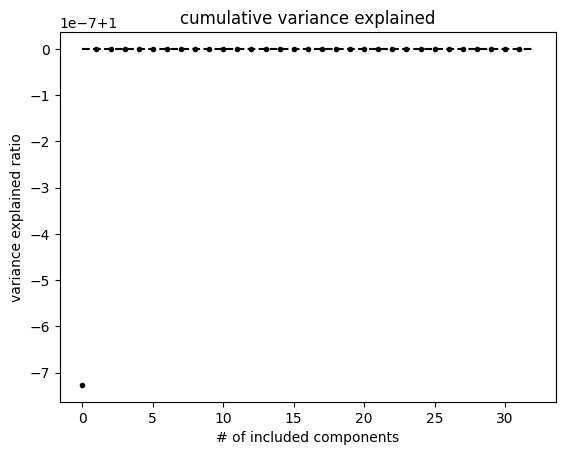

In [14]:
# explained variance plot
plt.figure()
plt.plot(pca_slice.explained_variance_ratio_.cumsum(),'k.')
plt.plot([0,pca_slice.n_components],[1,1],'k--')
plt.xlabel('# of included components')
plt.ylabel('variance explained ratio')
plt.title('cumulative variance explained')

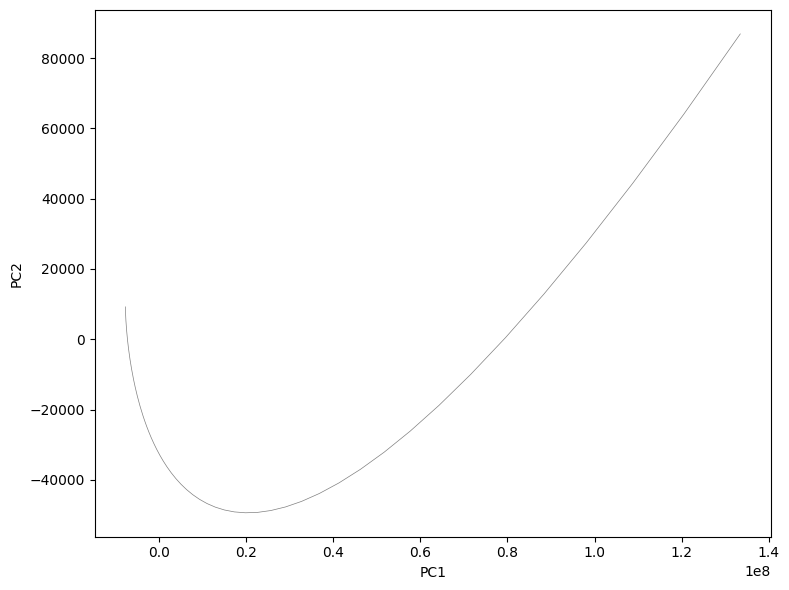

In [15]:
# # activation projections
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(s_slice[:,0], s_slice[:,1], '-k', linewidth=0.5, alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
plt.tight_layout()

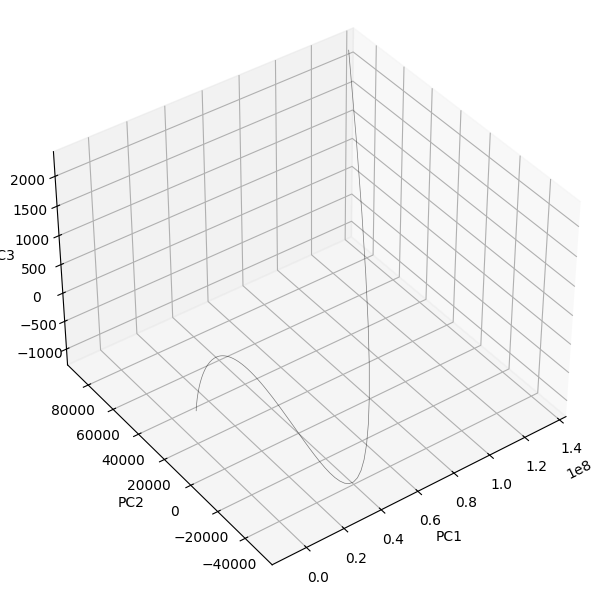

In [16]:
# # activation projections
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(s_slice[:,0], s_slice[:,1], s_slice[:,2], '-k', linewidth=0.5, alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.view_init(39,-126)
plt.tight_layout()

### Graff dirichlet functionalities

In [ ]:
def dirichlet_energy(edge_index, n, X, edge_weight=None, norm_type=None):
  edge_index, L = get_laplacian(edge_index, edge_weight, norm_type)
  LX = torch_sparse.spmm(edge_index, L, n, n, X)
  # return torch.sum(torch.trace(X.T @ de))
  return (X * LX).sum()

def rayleigh_quotient(edge_index, n, X, edge_weight=None):
  energy = dirichlet_energy(edge_index, n, X, edge_weight, 'sym')
  rayleigh = energy / torch.pow(torch.norm(X, p="fro"), 2)
  return rayleigh

def W_dirichlet_energy(X, edge_index, W):
    src_x = X[edge_index[0, :]]
    dst_x = X[edge_index[1, :]]
    deg = degree(edge_index[0, :], X.shape[0])
    deginvsqrt = deg.pow_(-0.5)
    src_deginvsqrt = deginvsqrt[edge_index[0, :]]
    dst_deginvsqrt = deginvsqrt[edge_index[1, :]]

    fWf = torch.einsum("ij,jk,ik->i", src_x * src_deginvsqrt.unsqueeze(dim=1), W,
                            dst_x * dst_deginvsqrt.unsqueeze(dim=1)).data
    return -0.5 * fWf.sum()

In [35]:
# for k in model.state_dict():
#     print(k, model.state_dict()[k].shape)
    
dirichlet_energy(edge_index, 2000, features, None, 'sym')
rayleigh_quotient(edge_index, 2000, features)

tensor(0.9543)